<a href="https://colab.research.google.com/github/BrMrtn/GoogleColab/blob/main/MI/IMSC_Transformers_lab_handout.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

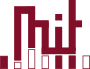 Mesterséges Intelligencia és Rendszertervezés Tanszék, ©2024. BME-MIT, Marosi Márk  
# **VIMIAC16 - Mesterséges Intelligencia**
## 2024. Őszi félév
## **iMSc Laborgyakorlat - Transzformer modellek**

## Overview

Welcome to the **IMSC Transformers Lab**! This lab is designed to provide you with hands-on experience in implementing and understanding key components of transformer models, including self-attention mechanisms, multi-head attention, positional encoding, and integrating these components into a complete Transformer-based language model. Additionally, you'll engage in visualization exercises to deepen your comprehension of how attention mechanisms and positional encodings function within transformers.

Each exercise builds upon the previous ones, guiding you through the incremental development of a transformer model. By the end of this lab, you will have implemented a working transformer language model trained on the WikiText-2 dataset.

In [1]:
# Install necessary packages
!pip install datasets accelerate -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 11.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [2]:
import math
import torch
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()


## Exercise 1: Understanding the Self-Attention Mechanism

In this exercise, you'll implement the `SelfAttentionLayer` class using the Scaled Dot-Product Attention (SDPA) approach. Self-attention allows the model to weigh the importance of different tokens in a sequence when encoding a particular token.

### Learning Objectives

- **Components of Self-Attention:** Understand the Query (`Q`), Key (`K`), and Value (`V`) matrices.
- **Attention Scores:** Implement the computation of attention scores and apply them to obtain the context layer.
- **Scaling and Softmax:** Grasp the role of scaling and softmax in normalizing attention scores.

### Mathematical Formulation

The self-attention mechanism can be mathematically expressed as:

$$
Attention(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right) V
$$

Where:
- $ Q $ is the Query matrix.
- $ K $ is the Key matrix.
- $ V $ is the Value matrix.
- $ d_k $ is the dimensionality of the key vectors.

### Instructions

1. **Compute Query (`Q`), Key (`K`), and Value (`V`) Matrices:**
   - Use linear layers to project the input sequence into `Q`, `K`, and `V`.
   - These projections allow the model to focus on different aspects of the input.

2. **Calculate Attention Scores:**
   - Perform a scaled dot-product between `Q` and the transpose of `K`.
   - Scaling by the square root of the hidden size stabilizes gradients during training.

3. **Apply Softmax to Obtain Attention Probabilities:**
   - Normalize the attention scores using the softmax function to convert them into probabilities.

4. **Compute the Context Layer:**
   - Multiply the attention probabilities with `V` to obtain the weighted sum, known as the context layer.

5. **Handle Optional Outputs:**
   - If `output_attentions` is `True`, return both the context layer and the attention probabilities.
   - Otherwise, return only the context layer.

### Code Skeleton


In [6]:
import math
import torch
from torch import nn
import torch.nn.functional as F

class SelfAttentionLayer(nn.Module):
    def __init__(self, hidden_size):
        super(SelfAttentionLayer, self).__init__()

        # Linear layers to project the input into Q, K, V
        self.query = nn.Linear(hidden_size, hidden_size, bias=False)
        self.key = nn.Linear(hidden_size, hidden_size, bias=False)
        self.value = nn.Linear(hidden_size, hidden_size, bias=False)

        # Scaling factor to stabilize gradients
        self.scale = math.sqrt(hidden_size)

    def forward(self, input_sequence, attention_mask=None, output_attentions=False):
        """
        Forward pass of the self-attention layer.

        Args:
            input_sequence (torch.Tensor): Input tensor of shape (batch_size, seq_len, hidden_size).
            attention_mask (torch.Tensor, optional): Mask to prevent attention to certain positions.
            output_attentions (bool, optional): If True, returns attention probabilities.

        Returns:
            tuple: (context_layer, attention_probs) if output_attentions is True,
                   otherwise (context_layer,)
        """
        # Step 1: Compute Q, K, V matrices
        Q = self.query(input_sequence)  # Shape: (batch_size, seq_len, hidden_size)
        K = self.key(input_sequence)    # Shape: (batch_size, seq_len, hidden_size)
        V = self.value(input_sequence)  # Shape: (batch_size, seq_len, hidden_size)

        # Step 2: Calculate attention scores using scaled dot-product
        attention_scores = torch.matmul(Q, K.transpose(-2, -1)) / self.scale  # Shape: (batch_size, seq_len, seq_len)

        # Step 3: Apply attention mask if provided
        if attention_mask is not None:
            # Apply the mask: set attention scores to -inf where mask is 0
            attention_scores = attention_scores.masked_fill(attention_mask == 0, float('-inf'))

        # Step 4: Apply softmax to obtain attention probabilities
        attention_probs = F.softmax(attention_scores, dim=-1)  # Shape: (batch_size, seq_len, seq_len)

        # Step 5: Compute the context layer by weighted sum of V
        context_layer = torch.matmul(attention_probs, V) # Shape: (batch_size, seq_len, hidden_size)

        # Step 6: Return context layer and optionally attention probabilities
        if output_attentions:
            return (context_layer, attention_probs)
        else:
            return (context_layer,)

In [7]:
# Test the SelfAttentionLayer class
hidden_size = 16

# Create a random input tensor with shape (batch_size=2, seq_len=5, hidden_size=16)
input_sequence = torch.randn(2, 5, hidden_size)

# Initialize the SelfAttentionLayer
self_attention_layer = SelfAttentionLayer(hidden_size=hidden_size)

# Perform a forward pass
output_sequence = self_attention_layer(input_sequence)[0]

# Print the shape of the output sequence
print("Output sequence shape:", output_sequence.shape)


Output sequence shape: torch.Size([2, 5, 16])


**Expected Output:**
```
Output sequence shape: torch.Size([2, 5, 16])
```

**Explanation:**
- The output shape matches the input shape, indicating that the self-attention layer preserves the sequence length and hidden size.


## Exercise 2: Visualizing Self-Attention Weights

Understanding how attention mechanisms operate internally can significantly enhance your grasp of transformer models. In this exercise, you'll compute and visualize the attention weights produced by the `SelfAttentionLayer`.

### Learning Objectives

- **Extract Attention Probabilities:** Obtain attention probabilities from the self-attention mechanism.
- **Visualization:** Visualize attention weights to interpret which tokens are attending to others.
- **Insights:** Gain insights into how the model focuses on different parts of the input sequence.

### Instructions

1. **Compute Attention Weights:**
   - Pass the input sequence through the `SelfAttentionLayer` with `output_attentions=True` to obtain both the context layer and attention probabilities.

2. **Visualize Attention Weights:**
   - Implement a function to plot the attention weights as a heatmap.
   - Focus on a specific example in the batch to analyze the attention distribution.


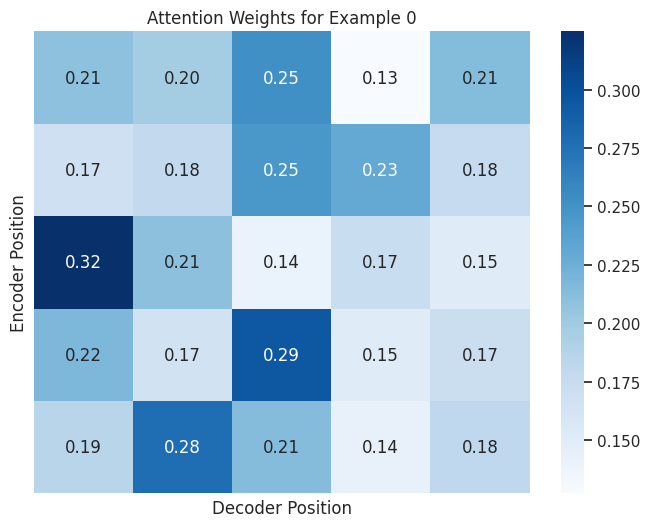

In [19]:
batch_size = input_sequence.size(0)

# Disable gradient computation for evaluation
with torch.no_grad():
    # Obtain both the context layer and attention weights
    output_sequence, attention_weights = self_attention_layer(input_sequence, output_attentions=True)

# Function to visualize attention weights
def plot_attention_weights(attention_weights, example=0):
    """
    Plots the attention weights for a given example in the batch.

    Args:
        attention_weights (torch.Tensor): Attention weights with shape (batch_size, seq_len, seq_len).
        example (int): Index of the example in the batch to visualize.
    """

    # Select the attention weights for the specified example
    attn = attention_weights[example].cpu().numpy()

    # Create a figure for the heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(attn, cmap='Blues', annot=True, fmt=".2f", xticklabels=False, yticklabels=False)
    plt.title(f"Attention Weights for Example {example}")
    plt.xlabel("Decoder Position")
    plt.ylabel("Encoder Position")
    plt.show()

# Plot attention weights for the first example in the batch
plot_attention_weights(attention_weights, example=0)

**Instructions for Implementation:**

- **Extracting Attention Weights:**
  - The `attention_weights` tensor has the shape `(batch_size, seq_len, seq_len)`.
  - Select the weights for a specific example (e.g., `example=0`) to visualize.

- **Creating the Heatmap:**
  - Use `matplotlib` and `seaborn` to generate a heatmap.
  - Label the axes with token positions to interpret which tokens are attending to others.

## Exercise 3: Implementing Multi-Head Self-Attention

Single-head attention can limit the model's ability to capture diverse aspects of the input. Multi-head attention addresses this by allowing the model to attend to information from different representation subspaces simultaneously.

### Learning Objectives

- **Multi-Head Concept:** Understand the concept and benefits of multi-head attention.
- **Implementation:** Implement the `MultiHeadSelfAttentionLayer` class to handle multiple attention heads.
- **Concatenation and Combination:** Learn how to concatenate and combine outputs from different heads.

### Instructions

1. **Initialize Multi-Head Components:**
   - Ensure that `hidden_size` is divisible by the number of attention heads (`num_attention_heads`).
   - Define separate linear layers for Query, Key, and Value projections.
   - Include a final linear layer to combine the outputs of all heads into a single tensor.

2. **Implement the Forward Pass:**
   - Split the input embeddings into multiple heads.
   - Perform scaled dot-product attention for each head independently.
   - Concatenate the outputs from all heads.
   - Apply the final linear layer to integrate the information from all heads.

### Code Skeleton


In [22]:
class MultiHeadSelfAttentionLayer(nn.Module):
    def __init__(self, hidden_size, num_attention_heads):
        super(MultiHeadSelfAttentionLayer, self).__init__()

        # Validate that hidden_size is divisible by num_attention_heads
        if hidden_size % num_attention_heads != 0:
            raise ValueError(
                f"The hidden size ({hidden_size}) is not a multiple of the number of attention heads ({num_attention_heads})"
            )

        self.num_attention_heads = num_attention_heads
        self.attention_head_size = hidden_size // num_attention_heads
        self.all_head_size = self.num_attention_heads * self.attention_head_size

        # Linear layers for Query, Key, and Value projections
        self.query = nn.Linear(hidden_size, self.all_head_size, bias=False)
        self.key = nn.Linear(hidden_size, self.all_head_size, bias=False)
        self.value = nn.Linear(hidden_size, self.all_head_size, bias=False)

        # Scaling factor for attention scores
        self.scale = math.sqrt(self.attention_head_size)

        # Final linear layer to combine all heads
        self.out = nn.Linear(self.all_head_size, hidden_size, bias=False)

    def transpose_for_scores(self, x):
        """
        Transposes the input tensor to separate the attention heads.

        Args:
            x (torch.Tensor): Tensor with shape (batch_size, seq_len, all_head_size).

        Returns:
            torch.Tensor: Transposed tensor with shape (batch_size, num_heads, seq_len, head_size).
        """
        new_x_shape = x.size()[:-1] + (self.num_attention_heads, self.attention_head_size)
        x = x.view(*new_x_shape)
        return x.permute(0, 2, 1, 3)

    def forward(self, input_sequence, attention_mask=None, output_attentions=False):
        """
        Forward pass of the multi-head self-attention layer.

        Args:
            input_sequence (torch.Tensor): Input tensor of shape (batch_size, seq_len, hidden_size).
            attention_mask (torch.Tensor, optional): Mask to prevent attention to certain positions.
            output_attentions (bool, optional): If True, returns attention probabilities.

        Returns:
            tuple: (output_sequence, attention_probs) if output_attentions is True,
                   otherwise (output_sequence,)
        """
        # Step 1: Compute Q, K, V matrices using linear projections
        mixed_query = self.query(input_sequence)  # Shape: (batch_size, seq_len, all_head_size)
        mixed_key = self.key(input_sequence)      # Shape: (batch_size, seq_len, all_head_size)
        mixed_value = self.value(input_sequence)  # Shape: (batch_size, seq_len, all_head_size)

        # Step 2: Reshape and transpose for multi-head attention
        query = self.transpose_for_scores(mixed_query)  # Shape: (batch_size, num_heads, seq_len, head_size)
        key = self.transpose_for_scores(mixed_key)      # Shape: (batch_size, num_heads, seq_len, head_size)
        value = self.transpose_for_scores(mixed_value)  # Shape: (batch_size, num_heads, seq_len, head_size)

        # Step 3: Compute scaled dot-product attention
        # Perform matrix multiplication between query and key^T
        # query: (batch_size, num_heads, seq_len, head_size)
        # key.transpose(-2, -1): (batch_size, num_heads, head_size, seq_len)
        attention_scores = torch.matmul(query, key.transpose(-2, -1)) / self.scale  # shape: (batch_size, num_heads, seq_len, seq_len)



        # (Optional) Apply attention mask if provided
        if attention_mask is not None:
            attention_scores = attention_scores.masked_fill(attention_mask == 0, float('-inf'))

        # Step 4: Apply softmax to obtain attention probabilities
        attention_probs = F.softmax(attention_scores, dim=-1)

        # Step 5: Apply attention probabilities to V to get the context layer
        context_layer = torch.matmul(attention_probs, value)  # Shape: (batch_size, num_heads, seq_len, head_size)

        # Step 6: Concatenate the context layers from all heads
        context_layer = context_layer.permute(0, 2, 1, 3).contiguous()  # Shape: (batch_size, seq_len, num_heads, head_size)
        new_context_layer_shape = context_layer.size()[:-2] + (self.all_head_size,)
        context_layer = context_layer.view(*new_context_layer_shape)  # Shape: (batch_size, seq_len, all_head_size)

        # Step 7: Pass the concatenated context layer through the final linear layer
        output_sequence = self.out(context_layer) # Shape: (batch_size, seq_len, hidden_size)

        # Step 8: Return output sequence and optionally attention probabilities
        if output_attentions:
            return (output_sequence, attention_probs)
        else:
            return (output_sequence,)


In [23]:
# Test the MultiHeadSelfAttentionLayer class
num_attention_heads = 4
hidden_size = 16

# Initialize the MultiHeadSelfAttentionLayer
multi_head_self_attention_layer = MultiHeadSelfAttentionLayer(hidden_size=hidden_size, num_attention_heads=num_attention_heads)

# Perform a forward pass
output_sequence = multi_head_self_attention_layer(input_sequence)[0]

# Print the shape of the output sequence
print("Output sequence shape:", output_sequence.shape)

Output sequence shape: torch.Size([2, 5, 16])


**Expected Output:**
```
Output sequence shape: torch.Size([2, 5, 16])
```

**Explanation:**
- The output shape matches the input shape, confirming that multi-head attention correctly integrates multiple attention heads while preserving the sequence length and hidden size.


## Exercise 4: Visualizing Multi-Head Self-Attention Weights

Multi-head attention allows the model to focus on different parts of the input sequence simultaneously. Visualizing the attention weights for individual heads can provide deeper insights into how each head contributes to the overall attention mechanism.

### Learning Objectives

- **Extract and Interpret:** Extract and interpret attention weights from different heads.
- **Visualization:** Visualize attention distributions for specific heads to understand their unique focus areas.
- **Diversity Analysis:** Analyze the diversity of attention patterns across multiple heads.

### Instructions

1. **Compute Attention Weights:**
   - Pass the input sequence through the `MultiHeadSelfAttentionLayer` with `output_attentions=True` to obtain attention probabilities for all heads.

2. **Visualize Attention Weights for a Specific Head:**
   - Implement a function to plot the attention weights for a chosen head and example in the batch.

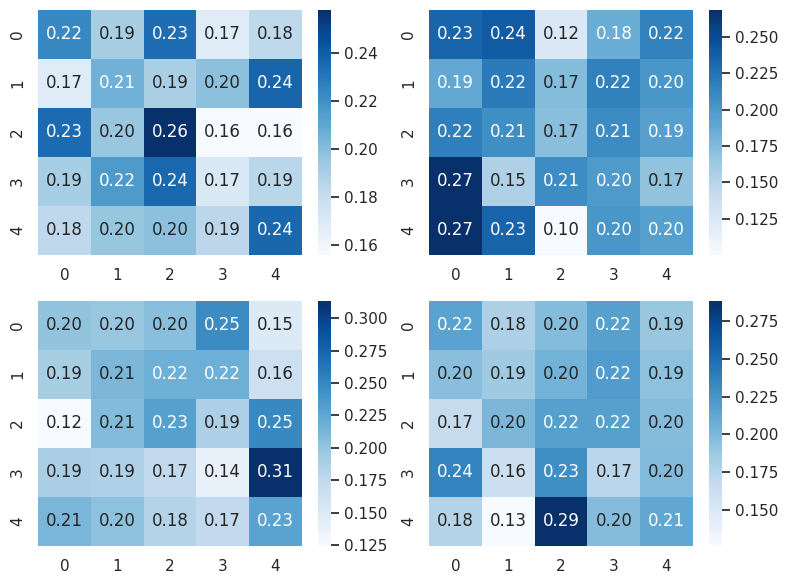

In [31]:
batch_size = input_sequence.size(0)

# Disable gradient computation for evaluation
with torch.no_grad():
    # Obtain both the output sequence and attention weights
    output_sequence, attention_weights = multi_head_self_attention_layer(input_sequence, output_attentions=True)

# Function to visualize multi-head attention weights
def plot_multihead_attention_weights(attention_weights, head=0, example=0):
    """
    Plots the attention weights for a specific head and example in the batch.

    Args:
        attention_weights (torch.Tensor): Attention weights with shape (batch_size, num_heads, seq_len, seq_len).
        head (int): Index of the attention head to visualize.
        example (int): Index of the example in the batch to visualize.
    """

    # Select the attention weights for the specified example
    attn = attention_weights[example].cpu().numpy()

    # Create a figure for the heatmap
    fig, ax = plt.subplots(2, 2, figsize=(8, 6))
    for i in range(2):
        for j in range(2):
          sns.heatmap(attn[i * 2 + j], cmap='Blues', annot=True, fmt=".2f", ax=ax[i, j])
    plt.tight_layout()
    plt.show()

# Plot attention weights for the first head and first example in the batch
plot_multihead_attention_weights(attention_weights, head=0, example=0)


**Instructions for Implementation:**

- **Selecting Specific Attention Weights:**
  - The `attention_weights` tensor has the shape `(batch_size, num_heads, seq_len, seq_len)`.
  - Choose a specific head (e.g., `head=0`) and example (e.g., `example=0`) to visualize.

- **Creating the Heatmap:**
  - Use `matplotlib` and `seaborn` to generate a heatmap for the selected head and example.
  - Label the axes with token positions to interpret the attention focus.


## Exercise 5: Positional Encoding

Transformers lack inherent information about the order of tokens in a sequence. Positional encoding injects this sequential information into the model, enabling it to capture the order and relative positions of tokens.

### Learning Objectives

- **Necessity of Positional Encoding:** Understand why positional encoding is essential in transformer models.
- **Implementation:** Implement the `PositionalEncoding` class using sinusoidal functions.
- **Integration:** Integrate positional encoding with token embeddings.

### Instructions

1. **Initialize Positional Encoding Matrix:**
   - Create a matrix using sinusoidal functions based on the position and embedding dimensions.
   - Register this matrix as a buffer to ensure it is not treated as a learnable parameter.

2. **Implement the Forward Pass:**
   - Add the positional encoding to the input embeddings.
   - Apply dropout for regularization to prevent overfitting.
   
### Code Skeleton

In [32]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_len=5000):
        """
        Initializes the PositionalEncoding module.

        Args:
            d_model (int): The dimension of the embeddings.
            max_seq_len (int, optional): The maximum sequence length. Defaults to 5000.
        """
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=0.1)

        # Create a matrix of positional encodings with shape (max_seq_len, d_model)
        pe = torch.zeros(max_seq_len, d_model)
        position = torch.arange(0, max_seq_len, dtype=torch.float).unsqueeze(1)  # Shape: (max_seq_len, 1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))  # Shape: (d_model/2,)

        # Apply sine to even indices in the embedding dimension
        pe[:, 0::2] = torch.sin(position * div_term)
        # Apply cosine to odd indices in the embedding dimension
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # Shape: (1, max_seq_len, d_model)

        # Register pe as a buffer to prevent it from being updated during training
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        Forward pass of the positional encoding layer.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, seq_len, d_model).

        Returns:
            torch.Tensor: Output tensor with positional encodings added, shape (batch_size, seq_len, d_model).
        """
        # Ensure the input sequence length does not exceed max_seq_len
        seq_len = x.size(1)
        if seq_len > self.pe.size(1):
            raise ValueError(f"Sequence length {seq_len} exceeds maximum length {self.pe.size(1)}")

        # Add positional encoding to the input embeddings
        x = x + self.pe[:, :seq_len, :]

        # Apply dropout for regularization
        return self.dropout(x)

In [33]:
# Test the PositionalEncoding class
seq_len = 20
d_model = 512

# Initialize the PositionalEncoding module
positional_encoder = PositionalEncoding(d_model=d_model, max_seq_len=seq_len)

# Create a random input tensor representing token embeddings
input_embeddings = torch.randn(1, seq_len, d_model)  # Shape: (batch_size=1, seq_len=20, d_model=512)

# Apply positional encoding
output_embeddings = positional_encoder(input_embeddings)

# Print the shape of the output embeddings
print("Output embeddings shape:", output_embeddings.shape)

Output embeddings shape: torch.Size([1, 20, 512])


**Expected Output:**
```
Output embeddings shape: torch.Size([1, 20, 512])
```

**Explanation:**
- The output embeddings retain the same shape as the input, indicating that positional encoding successfully adds positional information without altering the embedding dimensions.


## Exercise 6: Visualizing Positional Encodings

Visualizing positional encodings helps in understanding how positional information is represented and integrated into the model. It showcases the sinusoidal patterns that encode token positions.

### Learning Objectives

- **Extraction:** Extract and interpret the positional encoding matrix.
- **Visualization:** Visualize the variation of positional encodings across different positions and embedding dimensions.
- **Comprehension:** Comprehend how positional encodings enable the model to capture token order.

### Instructions

1. **Extract Positional Encodings:**
   - Retrieve the positional encoding matrix from the `PositionalEncoding` instance.

2. **Plot the Encodings:**
   - Create a heatmap to visualize the positional encodings across different positions and embedding dimensions.
   - Observe the sinusoidal patterns that vary with position and dimension.
   
### Code Skeleton

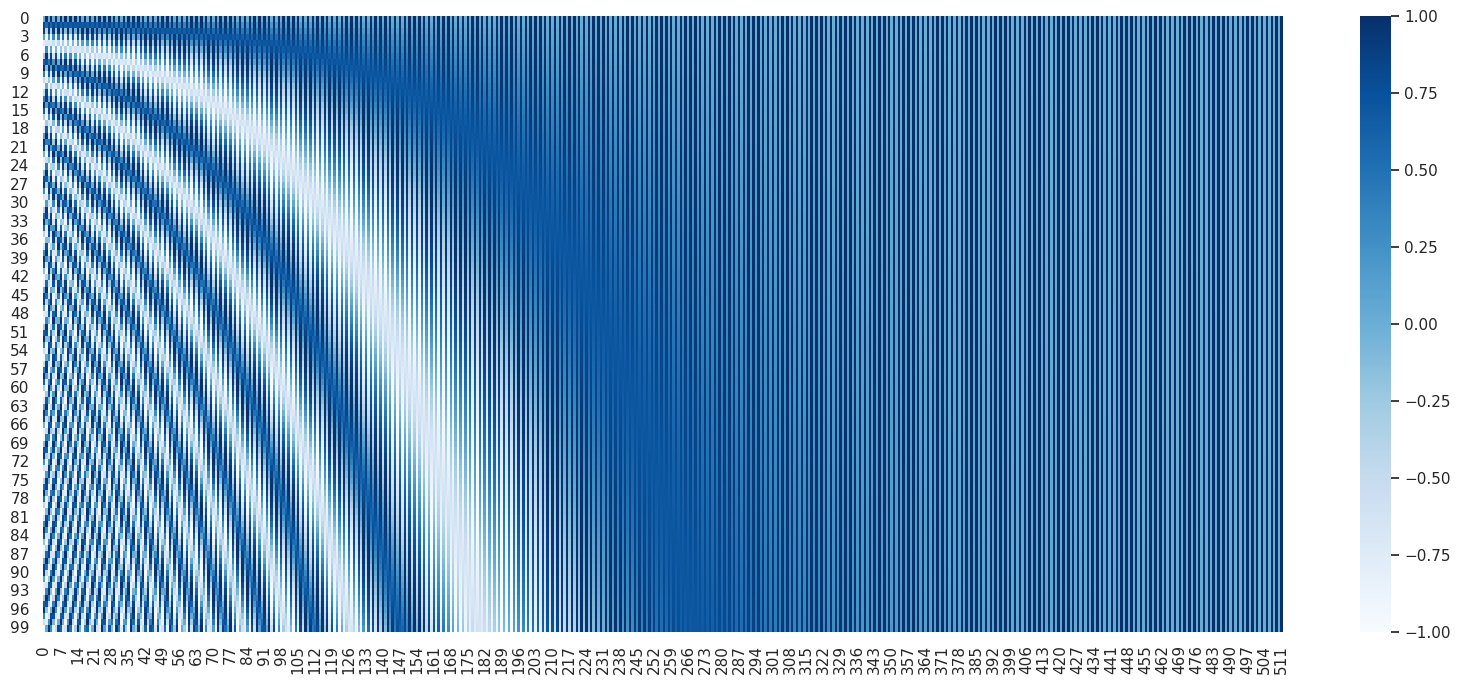

In [43]:
# Function to visualize positional encodings
def visualize_positional_encodings(positional_encoder, max_seq_len=100):
    """
    Visualizes the positional encodings.

    Args:
        positional_encoder (PositionalEncoding): Instance of the PositionalEncoding class.
        max_seq_len (int, optional): Number of positions to visualize. Defaults to 100.
    """

    # Extract the positional encoding matrix
    pe = positional_encoder.pe.squeeze(0)  # Shape: (max_seq_len, d_model)
    pe = pe[:max_seq_len, :]
    # Plot the Encodings
    plt.figure(figsize=(20, 8))
    sns.heatmap(pe, cmap='Blues', annot=False)
    plt.show()


# Test the visualization function with PositionalEncoding class
seq_len = 100
d_model = 512

# Initialize the PositionalEncoding module
positional_encoder = PositionalEncoding(d_model=d_model, max_seq_len=seq_len)

# Visualize the positional encodings
visualize_positional_encodings(positional_encoder, max_seq_len=seq_len)

**Instructions for Implementation:**

- **Extracting Positional Encodings:**
  - The positional encoding matrix `pe` has the shape `(1, max_seq_len, d_model)`.
  - Select the first batch (since it's identical across batches) and the desired sequence length.

- **Creating the Heatmap:**
  - Use `matplotlib` and `seaborn` to generate a heatmap of the positional encodings.
  - The heatmap should clearly display the sinusoidal variations across positions and embedding dimensions.


## Exercise 7: FeedForward Network

The FeedForward network is a crucial component of the Transformer architecture, enabling the model to capture complex patterns and interactions beyond the linear transformations of the attention mechanisms.

### Learning Objectives

- **Implementation:** Implement the FeedForward network with linear layers, activation functions, and dropout.
- **Role Understanding:** Understand the role of the FeedForward network in introducing non-linearity and increasing model capacity.

### Instructions

1. **Define the FeedForward Layers:**
   - The network consists of two linear transformations separated by a ReLU activation.
   - Apply dropout after the activation for regularization.

2. **Implement the Forward Pass:**
   - Pass the input through the first linear layer, apply ReLU, then through the second linear layer.
   - Apply dropout to the output.

### Code Skeleton


In [40]:
class FeedForward(nn.Module):
    def __init__(self, hidden_size, ff_size, dropout=0.1):
        """
        Initializes the FeedForward network.

        Args:
            hidden_size (int): The dimension of the input and output embeddings.
            ff_size (int): The dimension of the hidden layer in the FeedForward network.
            dropout (float, optional): Dropout probability. Defaults to 0.1.
        """
        super(FeedForward, self).__init__()
        self.linear1 = nn.Linear(hidden_size, ff_size)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(ff_size, hidden_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        """
        Forward pass of the feed-forward network.

        Args:
            x (torch.Tensor): Input tensor with shape (batch_size, seq_len, hidden_size).

        Returns:
            torch.Tensor: Output tensor with shape (batch_size, seq_len, hidden_size).
        """
        # Step 1: Apply the first linear transformation
        x = self.linear1(x)  # Shape: (batch_size, seq_len, ff_size)

        # Step 2: Apply ReLU activation
        x = self.relu(x) # Shape: (batch_size, seq_len, ff_size

        # Step 3: Apply the second linear transformation
        x = self.linear2(x)  # Shape: (batch_size, seq_len, hidden_size)

        # Step 4: Apply dropout for regularization
        x = self.dropout(x)

        return x

In [41]:
# Test the FeedForward class
hidden_size = 16
ff_size = 64

# Initialize the FeedForward network
feed_forward = FeedForward(hidden_size=hidden_size, ff_size=ff_size)

# Create a random input tensor with shape (batch_size=2, seq_len=5, hidden_size=16)
input_tensor = torch.randn(2, 5, hidden_size)

# Perform a forward pass
output_tensor = feed_forward(input_tensor)

# Print the shape of the output tensor
print("Output tensor shape:", output_tensor.shape)


Output tensor shape: torch.Size([2, 5, 16])


**Expected Output:**
```
Output tensor shape: torch.Size([2, 5, 16])
```

**Explanation:**
- The output shape matches the input shape, confirming that the FeedForward network correctly transforms the data while preserving the sequence length and hidden size.


## Exercise 8: Transformer Block

The Transformer block is the core building unit of transformer models, combining multi-head self-attention with a FeedForward network, along with residual connections and layer normalization.

### Learning Objectives

- **Integration:** Integrate multi-head self-attention and FeedForward networks within a Transformer block.
- **Residual Connections:** Implement residual connections and layer normalization to facilitate training.
- **Processing Flow:** Understand how each Transformer block processes and transforms the input data.

### Instructions

1. **Initialize Transformer Components:**
   - Incorporate the `MultiHeadSelfAttentionLayer` and `FeedForward` network.
   - Add layer normalization layers after each sub-component.
   - Include dropout layers for regularization.

2. **Implement the Forward Pass:**
   - Apply multi-head attention to the input, add a residual connection, and normalize.
   - Pass the result through the FeedForward network, add another residual connection, and normalize.

### Code Skeleton

In [42]:
class TransformerBlock(nn.Module):
    def __init__(self, hidden_size, num_attention_heads, ff_size, dropout=0.1):
        """
        Initializes the TransformerBlock.

        Args:
            hidden_size (int): The dimension of the input and output embeddings.
            num_attention_heads (int): Number of attention heads.
            ff_size (int): The dimension of the hidden layer in the FeedForward network.
            dropout (float, optional): Dropout probability. Defaults to 0.1.
        """
        super(TransformerBlock, self).__init__()
        self.multi_head_attention = MultiHeadSelfAttentionLayer(hidden_size, num_attention_heads)
        self.layer_norm1 = nn.LayerNorm(hidden_size)
        self.feed_forward = FeedForward(hidden_size, ff_size, dropout)
        self.layer_norm2 = nn.LayerNorm(hidden_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, attention_mask=None):
        """
        Forward pass of the transformer block.

        Args:
            x (torch.Tensor): Input tensor with shape (batch_size, seq_len, hidden_size).
            attention_mask (torch.Tensor, optional): Mask to prevent attention to certain positions.

        Returns:
            tuple: (x, attention_weights)
                - x (torch.Tensor): Output tensor with shape (batch_size, seq_len, hidden_size).
                - attention_weights (torch.Tensor): Attention weights with shape (batch_size, num_heads, seq_len, seq_len).
        """
        # Step 1: Multi-head self-attention
        attention_output, attention_weights = self.multi_head_attention(x, attention_mask=attention_mask, output_attentions=True)

        # Step 2: Add residual connection and apply layer normalization
        x = x + self.dropout(attention_output)
        dropout(attention_output)

        # Step 3: FeedForward network
        ff_output = self.feed_forward(x)  # Shape: (batch_size, seq_len, hidden_size)

        # Step 4: Add residual connection and apply layer normalization
        x = x + self.dropout(ff_output)    # Residual connection
        x = self.layer_norm2(x)

        return x, attention_weights

In [44]:
# Test the TransformerBlock class
hidden_size = 16
num_attention_heads = 4
ff_size = 64

# Initialize the TransformerBlock
transformer_block = TransformerBlock(hidden_size=hidden_size, num_attention_heads=num_attention_heads, ff_size=ff_size)

# Perform a forward pass
output, attention_weights = transformer_block(input_sequence)

# Print the shapes of the outputs
print("Transformer Block output shape:", output.shape)
print("Attention weights shape:", attention_weights.shape)

NameError: name 'dropout' is not defined

**Expected Output:**
```
Transformer Block output shape: torch.Size([2, 5, 16])
Attention weights shape: torch.Size([2, 4, 5, 5])
```

**Explanation:**
- The output shape matches the input shape, indicating that the Transformer block preserves the sequence length and hidden size.
- The attention weights shape reflects the number of heads and the attention distribution across the sequence.


## Exercise 9: Transformer Language Model Implementation

Integrate all the components you've built so far to implement a complete Transformer-based language model. This model will consist of token embeddings, positional encodings, multiple Transformer blocks, and an output layer to generate logits for each token in the vocabulary.

### Learning Objectives

- **Assembly:** Assemble the components of the Transformer architecture into a cohesive language model.
- **Data Flow Understanding:** Understand the flow of data through embeddings, positional encoding, Transformer blocks, and the output layer.
- **Preparation for Training:** Prepare the model for training on language modeling tasks.

### Instructions

1. **Define the Transformer Language Model Structure:**
   - Include token embedding and positional encoding layers.
   - Stack multiple Transformer blocks.
   - Apply layer normalization before the output layer.

2. **Implement the Forward Pass:**
   - Pass input token IDs through the embedding layer.
   - Add positional encodings.
   - Sequentially pass the data through each Transformer block.
   - Normalize the final embeddings and project them to the vocabulary size using a linear layer.

### Code Skeleton

In [ ]:
class TransformerLanguageModel(nn.Module):
    def __init__(self, vocab_size, hidden_size, num_attention_heads, num_layers, ff_size, max_seq_len, dropout=0.1):
        """
        Initializes the TransformerLanguageModel.

        Args:
            vocab_size (int): Size of the vocabulary.
            hidden_size (int): The dimension of the embeddings.
            num_attention_heads (int): Number of attention heads in each Transformer block.
            num_layers (int): Number of Transformer blocks.
            ff_size (int): The dimension of the hidden layer in the FeedForward network.
            max_seq_len (int): Maximum sequence length.
            dropout (float, optional): Dropout probability. Defaults to 0.1.
        """
        super(TransformerLanguageModel, self).__init__()

        # Token embedding layer
        self.embedding = nn.Embedding(vocab_size, hidden_size)

        # Positional encoding layer
        self.positional_encoding = PositionalEncoding(d_model=hidden_size, max_seq_len=max_seq_len)

        # Dropout layer applied after adding positional encodings
        self.dropout = nn.Dropout(dropout)

        # Stack of Transformer blocks
        self.layers = nn.ModuleList([
            TransformerBlock(hidden_size, num_attention_heads, ff_size, dropout) for _ in range(num_layers)
        ])

        # Final layer normalization
        self.layer_norm = nn.LayerNorm(hidden_size)

        # Output linear layer projecting to vocabulary size
        self.output_layer = nn.Linear(hidden_size, vocab_size)

    def forward(self, input_ids, attention_mask=None):
        """
        Forward pass of the transformer language model.

        Args:
            input_ids (torch.Tensor): Tensor of token indices with shape (batch_size, seq_len).
            attention_mask (torch.Tensor, optional): Mask to prevent attention to padding tokens.

        Returns:
            tuple: (logits, attention_weights)
                - logits (torch.Tensor): Logits for each token in the vocabulary with shape (batch_size, seq_len, vocab_size).
                - attention_weights (torch.Tensor): Attention weights from the last Transformer block with shape (batch_size, num_heads, seq_len, seq_len).
        """
        # Step 1: Obtain token embeddings
        embeddings = self.embedding(input_ids)  # Shape: (batch_size, seq_len, hidden_size)

        # Step 2: Add positional encoding to embeddings
        embeddings = ...  # Shape: (batch_size, seq_len, hidden_size)
        embeddings = ...  # Apply dropout

        # Initialize attention_weights to None
        attention_weights = None

        # Step 3: Pass embeddings through each Transformer block
        for layer in self.layers:
            embeddings, attention_weights = ...

        # Step 4: Apply final layer normalization
        embeddings = ...  # Shape: (batch_size, seq_len, hidden_size)

        # Step 5: Project embeddings to vocabulary size to obtain logits
        logits = ...  # Shape: (batch_size, seq_len, vocab_size)

        return logits, attention_weights

## Exercise 10: Training the Transformer Language Model

With the Transformer language model implemented, the next step is to train it on a real dataset. This exercise guides you through setting up the training loop, preparing the data, and optimizing the model.

### Learning Objectives

- **Data Preparation:** Prepare and preprocess data for language modeling tasks.
- **Model Configuration:** Initialize and configure the Transformer language model.
- **Training Implementation:** Implement a training loop to optimize the model on the WikiText-2 dataset.
- **Performance Monitoring:** Monitor training progress and evaluate model performance using perplexity.

### Instructions

1. **Setup:**
   - Import necessary libraries for data handling, tokenization, and training.
   - Load the WikiText-2 dataset and preprocess it for language modeling.

2. **Data Preparation:**
   - Initialize a tokenizer to convert text into token IDs.
   - Tokenize the training and validation datasets.
   - Create data loaders with appropriate batching and collating.

3. **Model Initialization:**
   - Define hyperparameters such as vocabulary size, hidden size, number of attention heads, number of layers, FeedForward size, sequence length, dropout rate, learning rate, and number of epochs.
   - Initialize the `TransformerLanguageModel` with these hyperparameters.

4. **Training Setup:**
   - Move the model to the appropriate device (GPU or CPU).
   - Define the optimizer (e.g., AdamW) and the loss function (CrossEntropyLoss with padding token ignored).

5. **Training Loop:**
   - Iterate over epochs, performing training and evaluation in each.
   - For each batch, perform forward propagation, compute the loss, perform backpropagation, and update the model parameters.
   - After each epoch, evaluate the model on the validation set and compute perplexity to assess performance.

### Code Skeleton


In [ ]:
# Import necessary libraries
from transformers import GPT2Tokenizer, DataCollatorForLanguageModeling, get_linear_schedule_with_warmup
from datasets import load_dataset
from torch.utils.data import DataLoader
import torch
import torch.optim as optim
from tqdm.auto import tqdm
import math

In [ ]:
# Initialize GPT-2 tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token  # Define a padding token if necessary


# Load the WikiText-2 dataset using the datasets library
train_dataset = load_dataset("wikitext", "wikitext-2-raw-v1", split="train")
validation_dataset = load_dataset("wikitext", "wikitext-2-raw-v1", split="validation")

# Define a tokenization function to process the text data
def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True, max_length=512)

# Apply the tokenization function to the training dataset
tokenized_train = train_dataset.map(tokenize_function, batched=True, remove_columns=["text"])

# Apply the tokenization function to the validation dataset
tokenized_validation = validation_dataset.map(tokenize_function, batched=True, remove_columns=["text"])

# Set the format of the datasets to PyTorch tensors
tokenized_train.set_format(type='torch', columns=['input_ids', 'attention_mask'])
tokenized_validation.set_format(type='torch', columns=['input_ids', 'attention_mask'])

# Initialize a data collator for language modeling (no masking as we're doing causal LM)
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

# Create data loaders for training and validation
train_loader = DataLoader(tokenized_train, batch_size=16, shuffle=True, collate_fn=data_collator)
validation_loader = DataLoader(tokenized_validation, batch_size=16, shuffle=False, collate_fn=data_collator)


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/36718 [00:00<?, ? examples/s]

Map:   0%|          | 0/3760 [00:00<?, ? examples/s]

In [ ]:
# Model Initialization

# Define hyperparameters
vocab_size = tokenizer.vocab_size        # Size of the tokenizer's vocabulary
hidden_size = 256                        # Embedding and hidden size of the model
num_attention_heads = 4                  # Number of attention heads in each Transformer block
num_layers = 4                           # Number of Transformer blocks
ff_size = 1024                           # Hidden size of the FeedForward network
max_seq_len = 512                        # Maximum sequence length the model can handle
dropout = 0.1                            # Dropout rate for regularization
learning_rate = 3e-4                     # Learning rate for the optimizer
num_epochs = 5                           # Number of training epochs

# Initialize the TransformerLanguageModel with the defined hyperparameters
model = TransformerLanguageModel(
    vocab_size=vocab_size,
    hidden_size=hidden_size,
    num_attention_heads=num_attention_heads,
    num_layers=num_layers,
    ff_size=ff_size,
    max_seq_len=max_seq_len,
    dropout=dropout
)


In [ ]:
# Training Setup

# Determine the device to run the model on (GPU if available, else CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.1, betas=(0.9, 0.95))

total_steps = len(train_loader) * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,
                                            num_training_steps=total_steps)


# Define the loss function (CrossEntropyLoss ignores padding tokens)
criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)


In [ ]:
def generate_causal_mask(seq_len):
    """
    Generates a lower triangular causal mask to prevent attention to future tokens.

    Args:
        seq_len (int): The length of the sequence.

    Returns:
        torch.Tensor: A tensor of shape (1, 1, seq_len, seq_len) containing the causal mask.
    """
    # Create a lower triangular matrix filled with 1s
    causal_mask = ...  # Shape: (1, 1, seq_len, seq_len)
    return causal_mask

def create_combined_mask(attention_mask, seq_len):
    """
    Combines the causal mask with the padding mask.

    Args:
        attention_mask (torch.Tensor): Padding mask of shape (batch_size, seq_len).
        seq_len (int): The length of the sequence.

    Returns:
        torch.Tensor: Combined mask of shape (batch_size, 1, seq_len, seq_len).
    """
    # Generate causal mask
    causal_mask = generate_causal_mask(seq_len).to(attention_mask.device)  # Shape: (1, 1, seq_len, seq_len)

    # Expand attention_mask to (batch_size, 1, 1, seq_len)
    padding_mask = ...  # Shape: (batch_size, 1, 1, seq_len)

    # Combine masks: Logical AND to ensure both masks are applied
    combined_mask = causal_mask.bool() & padding_mask.bool()  # Broadcasting happens automatically

    return combined_mask  # Shape: (batch_size, 1, seq_len, seq_len)

In [ ]:
# Training Loop

for epoch in range(num_epochs):
    # Set the model to training mode
    model.train()
    total_loss = 0
    progress_bar = tqdm(train_loader, desc=f"Training Epoch {epoch+1}")

    for batch in progress_bar:
        # Move batch data to the designated device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        labels = input_ids.clone()  # For language modeling, labels are the input_ids shifted by one
        seq_len = input_ids.size(1)
        attention_mask = create_combined_mask(attention_mask, seq_len)

        # Zero the gradients before backpropagation
        optimizer.zero_grad()

        # Forward pass through the model
        logits, _ = model(input_ids=input_ids, attention_mask=attention_mask)

        # Shift logits and labels for next-token prediction
        # Predict the next token, so we exclude the last token in logits and the first token in labels
        shift_logits = logits[:, :-1, :].contiguous()
        shift_labels = labels[:, 1:].contiguous()

        # Compute the loss
        loss = criterion(shift_logits.view(-1, vocab_size), shift_labels.view(-1))

        # Backward pass and optimization step
        loss.backward()
        optimizer.step()

        # Accumulate the loss
        total_loss += loss.item()
        progress_bar.set_postfix({'Loss': loss.item()})

    # Calculate the average training loss for the epoch
    avg_train_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1} Training Loss: {avg_train_loss}")

    # Evaluation phase after each epoch
    model.eval()
    total_eval_loss = 0
    with torch.no_grad():
        for batch in tqdm(validation_loader, desc="Evaluating"):
            # Move batch data to the device
            input_ids = batch['input_ids'].to(device)
            seq_len = input_ids.size(1)
            attention_mask = batch['attention_mask'].to(device)
            attention_mask = create_combined_mask(attention_mask, seq_len)
            labels = input_ids.clone()

            # Forward pass through the model
            logits, _ = model(input_ids=input_ids, attention_mask=attention_mask)

            # Shift logits and labels for next-token prediction
            shift_logits = logits[:, :-1, :].contiguous()
            shift_labels = labels[:, 1:].contiguous()

            # Compute the loss
            loss = criterion(shift_logits.view(-1, vocab_size), shift_labels.view(-1))

            # Accumulate the evaluation loss
            total_eval_loss += loss.item()

    # Calculate the average evaluation loss and perplexity
    avg_eval_loss = total_eval_loss / len(validation_loader)
    perplexity = math.exp(avg_eval_loss)
    print(f"Epoch {epoch+1} Validation Loss: {avg_eval_loss}, Perplexity: {perplexity}\n")

**Notes:**

- **Batch Size:** A batch size of 16 is used, but you may adjust it based on your computational resources.
- **Hidden Size and FF Size:** Larger sizes can capture more complex patterns but require more memory and computation.
- **Number of Layers and Heads:** Increasing these can improve model performance but also increases computational requirements.
- **Learning Rate and Epochs:** These hyperparameters can be tuned for better convergence and performance.

**Understanding Perplexity:**

- **Perplexity** is a measure of how well a probability model predicts a sample. Lower perplexity indicates better performance.


## Exercise 11: Generating Text with the Trained Model

Now that you've trained your Transformer-based language model, it's time to see it in action! In this exercise, you'll implement a text generation function that allows the model to generate coherent text based on a given prompt. This will help you understand how the model leverages the learned patterns to produce meaningful continuations.

### Learning Objectives

- **Text Generation:** Learn how to generate text using the trained Transformer model.
- **Sampling Strategies:** Understand different strategies for sampling tokens during generation (e.g., greedy sampling, top-k sampling).
- **Attention Visualization:** (Optional) Visualize attention weights to gain insights into the model's focus during generation.

### Instructions

1. **Prepare the Model for Generation:**
   - Set the model to evaluation mode.
   - Ensure no gradients are computed during generation to speed up the process.

2. **Implement the Text Generation Function:**
   - Define a function that takes a prompt and generates a specified number of tokens.
   - Utilize sampling strategies like greedy sampling or top-k sampling to select the next token.

3. **Generate and Display Sample Texts:**
   - Use the function to generate text based on different prompts.
   - Observe the coherence and relevance of the generated text.

4. **(Optional) Visualize Attention Weights:**
   - Implement visualization of attention weights during generation to understand the model's focus.


In [ ]:
# Function to generate text using the trained model
def generate_text(model, tokenizer, prompt, max_length=50, temperature=1.0, top_k=50, device='cpu'):
    """
    Generates text using the trained Transformer language model.

    Args:
        model (nn.Module): Trained TransformerLanguageModel.
        tokenizer (PreTrainedTokenizer): Tokenizer corresponding to the model.
        prompt (str): Input text to prompt the generation.
        max_length (int, optional): Maximum number of tokens to generate. Defaults to 50.
        temperature (float, optional): Sampling temperature. Higher values increase randomness. Defaults to 1.0.
        top_k (int, optional): Top-k sampling. Only the top_k most probable tokens are considered. Defaults to 50.
        device (str, optional): Device to run the model on. Defaults to 'cpu'.

    Returns:
        str: Generated text.
    """
    model.eval()  # Set model to evaluation mode

    # Tokenize the prompt
    input_ids = tokenizer.encode(prompt, return_tensors='pt').to(device)  # Shape: (1, prompt_length)

    generated_ids = input_ids  # Initialize generated_ids with the prompt

    with torch.no_grad():
        for _ in range(max_length):
            # Get model predictions
            logits, attention_weights = model(generated_ids)

            # Get the logits for the last token
            last_token_logits = logits[:, -1, :] / temperature  # Shape: (1, vocab_size)

            # Apply top-k sampling
            top_k = min(top_k, last_token_logits.size(-1))  # Safety check
            probs = F.softmax(last_token_logits, dim=-1)
            top_k_probs, top_k_indices = torch.topk(probs, top_k, dim=-1)

            # Sample from the top-k probabilities
            sampled_token = torch.multinomial(top_k_probs, num_samples=1)
            sampled_token_id = top_k_indices.gather(-1, sampled_token)

            # Append the sampled token to the generated_ids
            generated_ids = torch.cat((generated_ids, sampled_token_id), dim=1)

    # Decode the generated token IDs to text
    generated_text = tokenizer.decode(generated_ids[0])#, skip_special_tokens=True)

    return generated_text


In [ ]:
# Define a list of prompts to generate text from
prompts = [
    "Once upon a time",
    "In a galaxy far, far away",
    "The future of AI",
    "Deep learning models are",
    "Transformers have revolutionized"
]

# Generate and print text for each prompt
for prompt in prompts:
    generated = generate_text(
        model=model,
        tokenizer=tokenizer,
        prompt=prompt,
        max_length=50,       # Number of tokens to generate
        temperature=0.7,     # Sampling temperature
        top_k=30,            # Top-k sampling
        device=device        # Device (CPU or GPU)
    )
    print(f"Prompt: {prompt}\nGenerated Text: {generated}\n{'-'*80}\n")


**Explanation:**

- **Prompts:** A list of seed texts to initiate generation.
- **Parameters:**
  - `max_length`: Limits the number of tokens generated to prevent excessively long outputs.
  - `temperature`: Controls randomness in sampling. Lower values make the model more confident (less random), while higher values increase diversity.
  - `top_k`: Restricts sampling to the top_k most probable tokens to balance creativity and coherence.
- **Output:** Displays the generated text for each prompt, separated by lines for clarity.


In [ ]:
# (Optional) Function to visualize attention weights during generation

def visualize_attention(generated_ids, attention_weights, tokenizer, head=0, example=0):
    """
    Visualizes the attention weights for a specific head and example.

    Args:
        generated_ids (torch.Tensor): Generated token IDs with shape (1, seq_len).
        attention_weights (torch.Tensor): Attention weights from the last Transformer block with shape (batch_size, num_heads, seq_len, seq_len).
        tokenizer (PreTrainedTokenizer): Tokenizer corresponding to the model.
        head (int, optional): Index of the attention head to visualize. Defaults to 0.
        example (int, optional): Index of the example in the batch to visualize. Defaults to 0.
    """
    # Decode the generated token IDs to tokens
    tokens = tokenizer.convert_ids_to_tokens(generated_ids[0])

    # Select the attention weights for the specified example and head
    attn = attention_weights[example, head].cpu().numpy()

    # Create a figure for the heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(attn, annot=True, fmt=".2f", cmap='Blues',
                xticklabels=tokens,
                yticklabels=tokens)
    plt.title(f'Attention Weights for Head {head}')
    plt.xlabel('Key Tokens')
    plt.ylabel('Query Tokens')
    plt.show()


In [ ]:
# Example usage of the visualize_attention function

# Generate text with attention weights
def generate_text_with_attention(model, tokenizer, prompt, max_length=50, temperature=1.0, top_k=50, device='cpu'):
    """
    Generates text using the trained Transformer language model and returns attention weights.

    Args:
        model (nn.Module): Trained TransformerLanguageModel.
        tokenizer (PreTrainedTokenizer): Tokenizer corresponding to the model.
        prompt (str): Input text to prompt the generation.
        max_length (int, optional): Maximum number of tokens to generate. Defaults to 50.
        temperature (float, optional): Sampling temperature. Higher values increase randomness. Defaults to 1.0.
        top_k (int, optional): Top-k sampling. Only the top_k most probable tokens are considered. Defaults to 50.
        device (str, optional): Device to run the model on. Defaults to 'cpu'.

    Returns:
        tuple: (generated_text, generated_ids, attention_weights)
            - generated_text (str): The generated text.
            - generated_ids (torch.Tensor): Generated token IDs.
            - attention_weights (torch.Tensor): Attention weights from the last Transformer block.
    """
    model.eval()  # Set model to evaluation mode

    # Tokenize the prompt
    input_ids = tokenizer.encode(prompt, return_tensors='pt').to(device)  # Shape: (1, prompt_length)

    generated_ids = input_ids  # Initialize generated_ids with the prompt

    attention_weights = None  # To store attention weights

    with torch.no_grad():
        for _ in range(max_length):
            # Get model predictions
            logits, attn_weights = model(generated_ids)

            # Get the logits for the last token
            last_token_logits = logits[:, -1, :] / temperature  # Shape: (1, vocab_size)

            # Apply top-k sampling
            top_k = min(top_k, last_token_logits.size(-1))  # Safety check
            probs = F.softmax(last_token_logits, dim=-1)
            top_k_probs, top_k_indices = torch.topk(probs, top_k, dim=-1)

            # Sample from the top-k probabilities
            sampled_token = torch.multinomial(top_k_probs, num_samples=1)
            sampled_token_id = top_k_indices.gather(-1, sampled_token)

            # Append the sampled token to the generated_ids
            generated_ids = torch.cat((generated_ids, sampled_token_id), dim=1)

            # Update attention_weights with the latest
            attention_weights = attn_weights

    # Decode the generated token IDs to text
    generated_text = tokenizer.decode(generated_ids[0], skip_special_tokens=True)

    return generated_text, generated_ids, attention_weights

# Select a prompt
prompt = "Artificial intelligence is transforming the world by"

# Generate text and capture attention weights
generated_text, generated_ids, attention_weights = generate_text_with_attention(
    model=model,
    tokenizer=tokenizer,
    prompt=prompt,
    max_length=30,       # Number of tokens to generate
    temperature=0.7,     # Sampling temperature
    top_k=50,            # Top-k sampling
    device=device        # Device (CPU or GPU)
)

# Print the generated text
print(f"Prompt: {prompt}\nGenerated Text: {generated_text}\n{'-'*80}\n")

# Visualize attention weights for a specific head
visualize_attention(generated_ids, attention_weights, tokenizer, head=0, example=0)

**Explanation:**

- **`generate_text_with_attention`:** Extends the previous `generate_text` function to also return the attention weights from the last Transformer block.
- **`visualize_attention`:** Uses the attention weights to create a heatmap showing how the model attended to different tokens during generation.
- **Example Usage:**
  - Generates text based on the prompt "Artificial intelligence is transforming the world by".
  - Prints the generated text.
  - Visualizes the attention weights for head `0` in the first example of the batch.


# Conclusion

Congratulations on completing the **IMSC Transformers Lab**! Through these exercises, you've implemented and trained a Transformer-based language model, gaining hands-on experience with critical components such as self-attention, multi-head attention, positional encoding, and the overall Transformer architecture. Additionally, visualization exercises have provided deeper insights into the inner workings of attention mechanisms and positional encodings.

**Key Takeaways:**

- **Self-Attention Mechanism:** Enables the model to weigh the importance of different tokens in a sequence.
- **Multi-Head Attention:** Allows the model to focus on various representation subspaces simultaneously, enhancing its capacity to capture diverse patterns.
- **Positional Encoding:** Injects sequential information into the model, enabling it to understand the order of tokens.
- **Transformer Blocks:** Integrate multi-head attention and FeedForward networks with residual connections and layer normalization, forming the backbone of transformer models.
- **Training:** Practical experience in setting up a training loop, preparing data, and optimizing model parameters.

**Next Steps:**

- **Experiment with Hyperparameters:** Adjust the number of layers, attention heads, hidden sizes, and learning rates to observe their effects on model performance.
- **Explore Different Datasets:** Train the model on other datasets to generalize your understanding and adapt the model to various language tasks.
- **Extend the Model:** Implement additional components such as encoder-decoder architectures, masked language modeling, or fine-tune the model for specific tasks like text classification or translation.
